In [4]:
import numpy as np
import scipy.io as sio
import ase
from ase.io import read
from lib import ase_view, traj_view
import matplotlib.pyplot as plt
import json

# Import data / read a dictionary

In [2]:
#Import a structure and view it
PbO=read("./PbO.xsf")
ase_view(PbO*(5,5,1))

A Jupyter Widget

A Jupyter Widget

In [6]:
#import a dataset
data=sio.loadmat("./qm7b.mat")
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'R', 'Z', 'T', 'P'])

In [8]:
# import a json
phonons=json.load(open("./PbO.json"))
phonons.keys()

dict_keys(['distances', 'natoms', 'repetitions', 'name', 'formula', 'vectors', 'chemical_symbols', 'qpoints', 'atom_numbers', 'lattice', 'atomic_numbers', 'highsym_qpts', 'highsym_qpoints', 'atom_pos_car', 'atom_pos_red', 'eigenvalues', 'atom_types'])

# Explore and manipulate data

In [9]:
# explore and manipulate data inside the dictionary
d={at:[] for at in set(PbO.numbers)}
for pos, at in zip(PbO.positions, PbO.numbers):
    d[at].append(pos)
print(d)

{8: [array([  0.        ,   0.        ,  11.19968713]), array([  2.04329885,   2.04329885,  11.19968713])], 82: [array([  0.        ,   2.04329885,  12.39937426]), array([  2.04329885,   0.        ,  10.        ])]}


In [10]:
# build descriptors
Cm=0
for specy, positions in d.items():
    Cm+=float(specy)*np.mean(positions,0)*len(positions)
print(Cm)

[  183.89689678   183.89689678  2015.94368365]


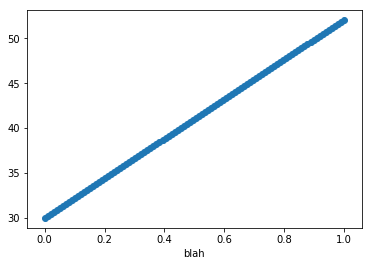

In [11]:
x=np.linspace(0,1, 100)
y=30+22*x
plt.scatter(x,y)
plt.xlabel("blah")
plt.show()